<a href="https://colab.research.google.com/github/albertopolini/DSIM/blob/main/EDSIM4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install opencv_contrib_python==3.4.2.17 --force-reinstall

import cv2 as cv
print(cv.__version__)
import numpy as np
from matplotlib import pyplot as plt

# Set visualization size for figures (notebook only)
plt.rcParams['figure.figsize'] = [15, 10] # width, height

3.4.2


#SIFT: Scale-Invariant Feature Transform

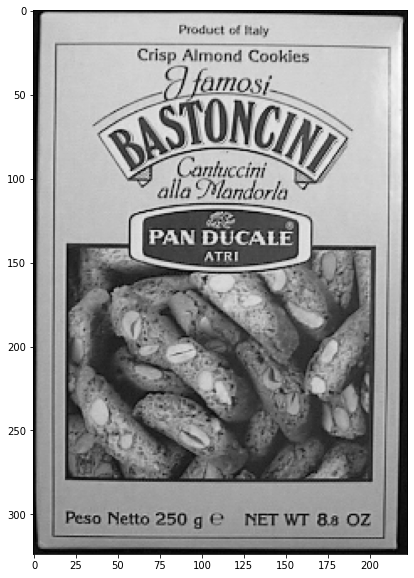

In [5]:
box = cv.imread('./images/box.png', 0)
plt.imshow(box, cmap='gray'); plt.show()

Detection and description of keypoints

In [6]:
# Instantiate SIFT

sift = cv.xfeatures2d.SIFT_create()

## Finding the keypoints

In [7]:
kps1, features1 = sift.detectAndCompute(box, None)

In [12]:
len(kps1)

604

In [13]:
type(kps1[0])

cv2.KeyPoint

In [15]:
print(dir(kps1[0]))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'angle', 'class_id', 'convert', 'octave', 'overlap', 'pt', 'response', 'size']


In [16]:
kps1[0].pt

(3.161376476287842, 204.0614776611328)

In [17]:
features1.shape

(604, 128)

## Visualizing the keypoints

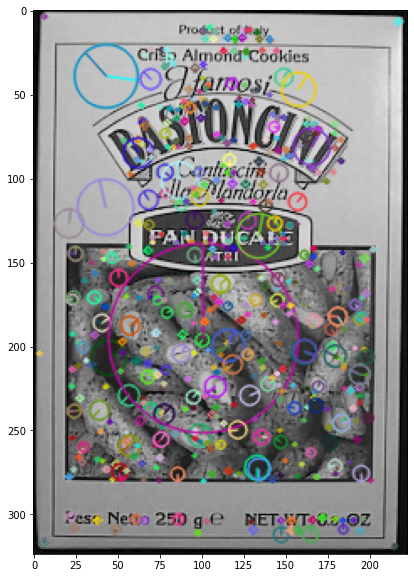

In [24]:
# Visualize the keypoints

box_kps = cv.drawKeypoints(box, kps1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(box_kps)

We get the scale and the angle of the keypoints

## Import a second image

In [26]:
scene = cv.imread('images/box_in_scene.png', 0)

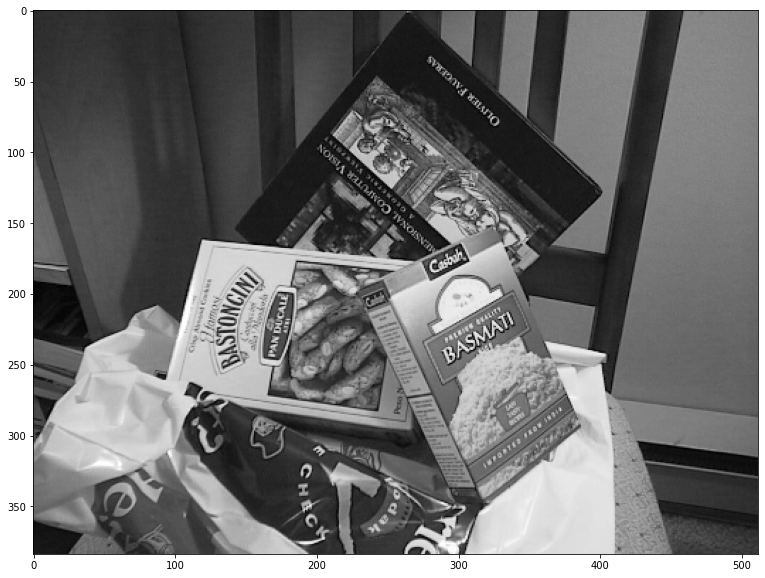

In [28]:
plt.imshow(scene, cmap='gray')

In [27]:
kps2, features2 = sift.detectAndCompute(scene, None)

## Matching operations

In [29]:
len(kps2)

969

In [30]:
# crossChech = True the comparison is computed in both directions
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1,features2)

In [36]:
len(matches)

398

In [37]:
type(matches[0])

cv2.DMatch

In [33]:
print(dir(matches[0]))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'distance', 'imgIdx', 'queryIdx', 'trainIdx']


**distance**: distance in the feature space

**imgIdx**

**queryIdx**: Index in the first image

**trainIdx**: index in the second image

In [40]:
matches[0].queryIdx

0

In [43]:
matches[0].trainIdx

# We have a correspondance between the point 0 of the first image and the point 881 of the second

881

## Visualize the matches

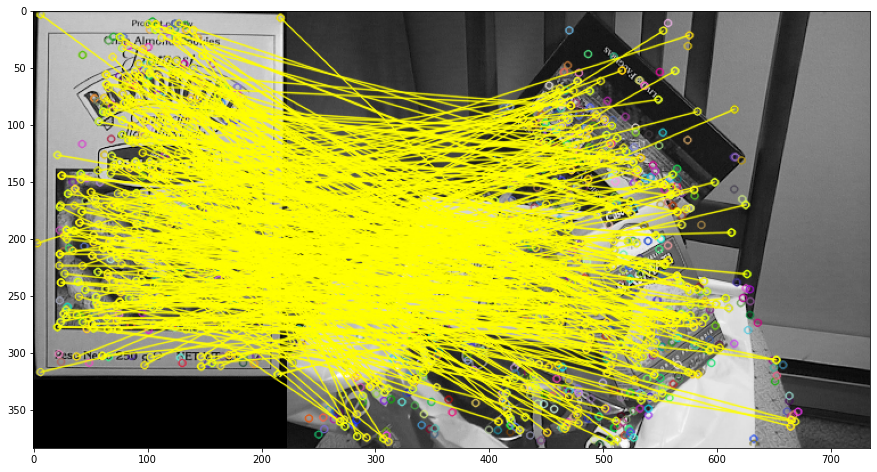

In [48]:
result = cv.drawMatches(box, kps1, scene, kps2, matches, None, matchColor=[255,255,0])

plt.imshow(result, cmap='gray')

We have a lot of false positives. We can use the distance information to improve the performances

In [49]:
matches = sorted(matches, key=lambda x: x.distance)

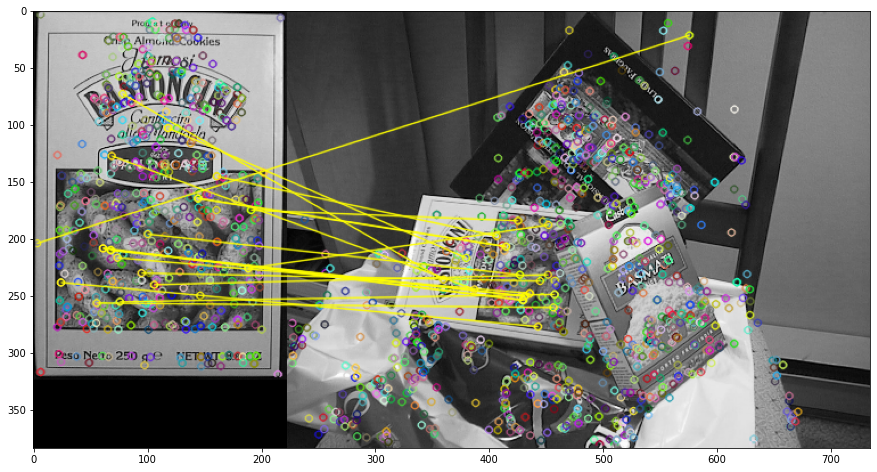

In [51]:
result = cv.drawMatches(box, kps1, scene, kps2, matches[0:20], None, matchColor=[255,255,0])

plt.imshow(result, cmap='gray')

# Image Stitching Assignment

In [195]:
boat1 = cv.imread('images/boat1.jpg', 0)
boat2 = cv.imread('images/boat3.jpg', 0)

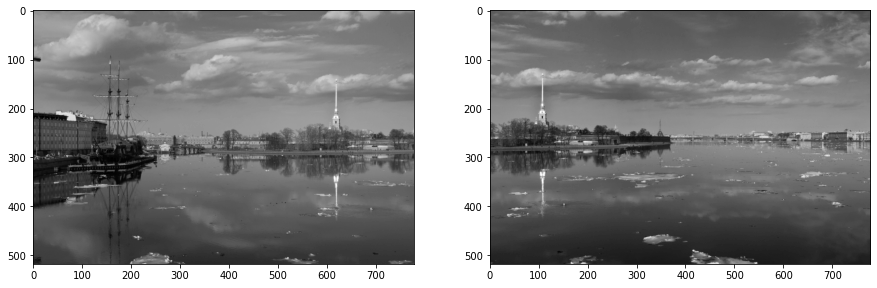

In [196]:
plt.subplot(1,2,1)
plt.imshow(boat1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(boat2, cmap='gray')

In [197]:
sift = cv.xfeatures2d.SIFT_create()
kps1, features1 = sift.detectAndCompute(boat1, None)
kps2, features2 = sift.detectAndCompute(boat2, None)

bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

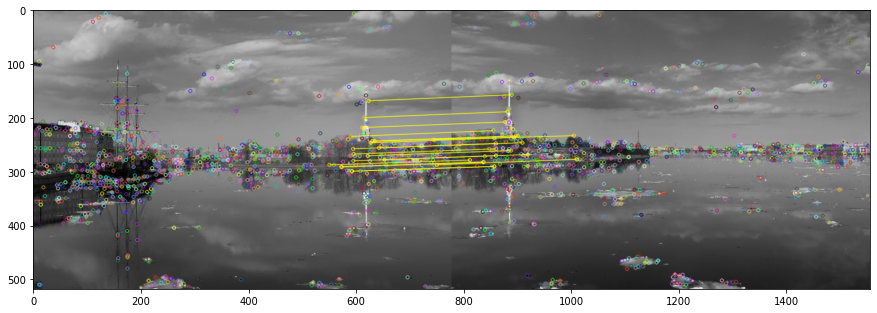

In [198]:
matches = sorted(matches, key=lambda x: x.distance)
result = cv.drawMatches(boat1, kps1, boat2, kps2, matches[0:20], None, matchColor=[255,255,0])

plt.imshow(result, cmap='gray')

Step 1: Find the homography that describes the transformation from the second set of keypoints to the first one

In [211]:
def myHomography(kps1,kps2, matches):

  matches = sorted(matches, key=lambda x: x.distance)[:20]

  srcIndex = [match.queryIdx for match in matches]
  dstIndex = [match.trainIdx for match in matches]

  srcPoints = np.float32([kps1[id].pt for id in srcIndex])
  dstPoints = np.float32([kps2[id].pt for id in dstIndex])

  H, _ =	cv.findHomography(dstPoints, srcPoints)
  
  return H

In [212]:
H = myHomography(kps1,kps2,matches)
H

array([[ 5.65213769e-01, -1.74435226e-02,  5.21924360e+02],
       [-1.52839572e-01,  9.13625152e-01,  3.05504509e+01],
       [-5.52535033e-04, -2.72898276e-05,  1.00000000e+00]])

Step 2: apply the homography to the second image

In [297]:
def myWarp(im, H):
  return cv.warpPerspective(im, H, dsize=(im.shape[1]*2, im.shape[0]))

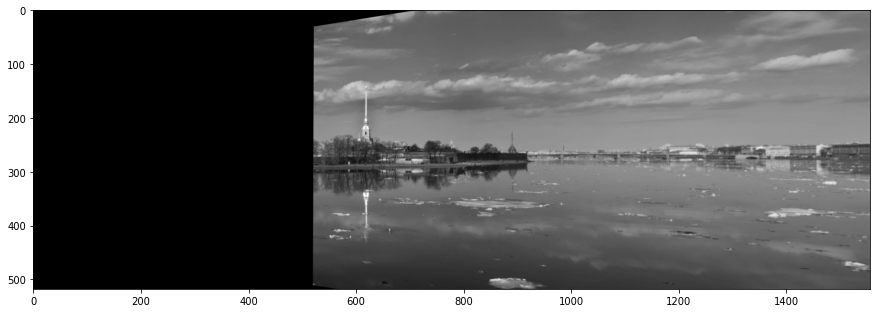

In [298]:
temp = myWarp(boat2, H)
plt.imshow(temp, cmap='gray')

Step 3: combine the two images

im_base[from_y, to_y, from_x, to_x] = boat1

In [302]:
def myCollage(im_base, im_new):
  im_base[:im_new.shape[0], :im_new.shape[1]] = im_new
  return im_base

In [303]:
collage = myCollage(temp, boat1)

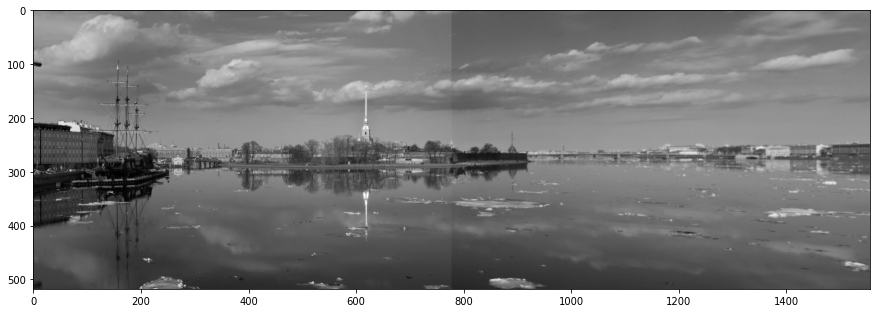

In [311]:
plt.imshow(collage, cmap='gray')
plt.show()

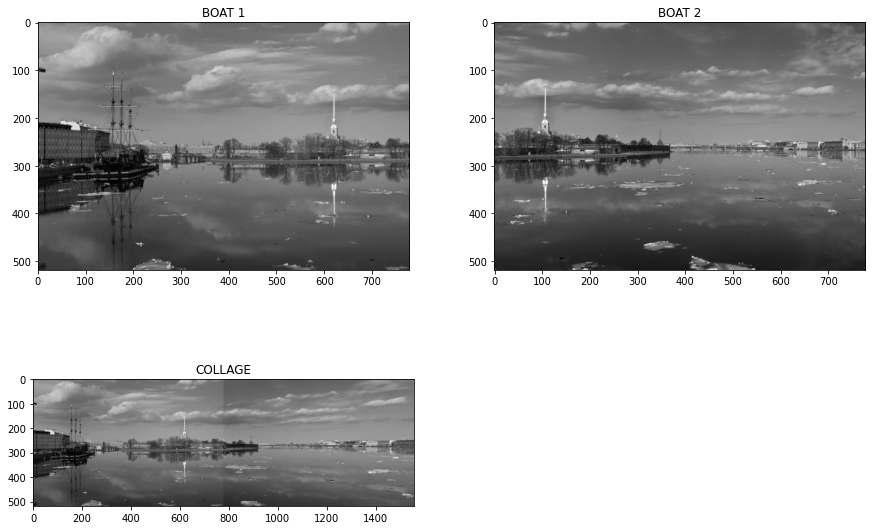

In [305]:
plt.subplot(2,2,1)
plt.title('BOAT 1')
plt.imshow(boat1, cmap='gray')

plt.subplot(2,2,2)
plt.title('BOAT 2')
plt.imshow(boat2, cmap='gray')

plt.subplot(2,2,3)
plt.title('COLLAGE')
plt.imshow(collage, cmap='gray')